# Custom mean functions: Meta-learning with GPs
One of the advantages of Gaussian process is their flexibility as a modelling tool. For instance, if the modeller knows there is an underlying trend in the data, they can specify a mean function that captures this trend.

In this notebook, we illustrate how to use GPflow to construct a custom neural network mean function for GPs that can capture complex trends. We look at this functionality in the context of meta-learning, where a number of metatasks are available at train time and the user wants to adapt a flexible model to new tasks at test time.

For an in-depth discussion on this topic, see *(Fortuin and Rätsch, 2019)*. This notebook reproduces section 4.2 of this paper.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
from gpflow.decors import params_as_tensors
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models import GPR
from gpflow.params import Parameter, ParamList
from gpflow.training import GradientDescentOptimizer

from gpflow.test_util import notebook_niter

%matplotlib inline

## Generate the tasks
To generate the meta and test tasks, we sample from a Gaussian process with an Squared Exponential covariance function and a sinusoidal mean function. Each task is a realisation of this process.

In [2]:
def generate_data(num_functions=10, N=1000):
    jitter = 1e-6
    Xs = np.linspace(-5.0, 5.0, N)[:, None]
    kernel = RBF(input_dim=1, lengthscales=1.)
    cov = kernel.compute_K_symm(Xs)
    L = np.linalg.cholesky(cov + np.eye(N) * jitter)
    epsilon = np.random.randn(N, num_functions)
    F = np.sin(Xs) + np.matmul(L, epsilon)
    return Xs, F

We generate 10 tasks for illustration.

In [3]:
Xs, F = generate_data(10)

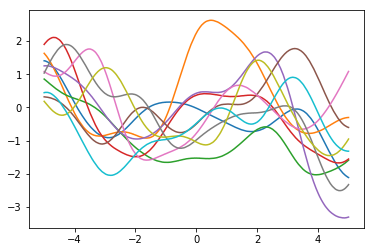

In [4]:
plt.plot(Xs, F);

We generate the meta and test tasks.

In [5]:
def generate_meta_and_test_tasks(num_datapoints, num_meta, num_test):
    N = 1000
    Xs, F = generate_data(num_functions=num_meta + num_test, N=N)
    meta_indices = [np.random.permutation(N)[:num_datapoints] for _ in range(num_meta)] 
    test_indices = [np.random.permutation(N)[:num_datapoints] for _ in range(num_test)]
    meta = []
    for i, mi in enumerate(meta_indices):
        Y = F[mi, i][:, None] + 1e-1 * np.random.randn(num_datapoints, 1)
        meta.append((Xs[mi], Y))
    test = []
    for i, ti in enumerate(test_indices):
        Y = F[ti, num_meta + i][:, None] + 1e-1 * np.random.randn(num_datapoints, 1)
        test.append(((Xs[ti], Y), (Xs, F[:, num_meta + i][:, None])))
    return meta, test

In [6]:
num_meta_tasks = 20
num_test_tasks = 5
num_datapoints = 5
meta, test = generate_meta_and_test_tasks(num_datapoints, num_meta_tasks, num_test_tasks)

## Create the mean function
To create a custom mean function in GPflow, we inherit from the `MeanFunction` class and implement a `__call__` method. We store the neural network parameter inside the object and implement the forward pass in `__call__`.

In [7]:
# Function for weight initialisation
def xavier_weights(input_dim, output_dim):
    """
    Xavier initialisation for the weights of a NN layer
    See:
       Xavier Glorot and Yoshua Bengio (2010):
       Understanding the difficulty of training deep feedforward neural networks.
       International Conference on Artificial Intelligence and Statistics.
    """

    xavier_std = (2./(input_dim + output_dim)) ** 0.5
    return np.random.randn(input_dim, output_dim) * xavier_std


# Neural network implementation
class DeepNeuralNetworkMeanFunction(MeanFunction):
    """
    Neural network mean function
    """
    def __init__(self, input_dim, output_dim, inner_dims=[100], inner_activation=tf.nn.tanh, seed=None, Ws=None, bs=None):
        """
        :param input_dim: input dimension
        :param output_dim: output dimension
        :param inner_dims: dimension of inner layers
        :param inner_activation: activation for inner layers
        :param seed: random seed
        :param mean_function: initialise the network with parameters from mean_function
        """

        super().__init__()

        self.seed = seed
        self.rng = np.random.RandomState(self.seed)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.inner_dims = inner_dims

        self.inner_activation = inner_activation

        if (Ws is None) and (bs is None):
            self._construct_network()
        else:
            self.Ws = ParamList(Ws) 
            self.bs = ParamList(bs)

    def _construct_network(self):
        Ws, bs = [], []
        dims = [self.input_dim, *self.inner_dims, self.output_dim]
        for dim_in, dim_out in zip(dims[:-1], dims[1:]):
            Ws.append(Parameter(xavier_weights(dim_in, dim_out), trainable=True))
            bs.append(Parameter(np.zeros((1, dim_out)), trainable=True))

        self.Ws, self.bs = ParamList(Ws), ParamList(bs)

    @params_as_tensors
    def __call__(self, X):
        """
        Feedforward pass

        :param X: NxD tensor
        """

        forward = X

        for i, (W, b) in enumerate(zip(self.Ws, self.bs)):
            forward = tf.matmul(forward, W) + b
            if i < len(self.bs) - 1:
                forward = self.inner_activation(forward)

        return forward

## Build the GP metamodel
Meta-learning boils down to learning a good prior that can generalise to new tasks with a small number of datapoints. This framework is prevalent in GP modelling, where we usually maximise the marginal likelihood to learn a good set of hyperparameters that specify the GP prior.

We perform the same optimisation here, while sharing the hyperparameters across all the metatasks. For simplicity, we fix the kernel and likelihood parameters and only learn those for the mean function. Hence, our "meta-learning" procedure is to cycle through the metatasks continuously, optimising their marginal likelihood until a convergence criteria is reached (here, we just implement a fixed number of iterations over the tasks).

To begin this process, first we create a utility function that takes in a task (X, Y) and a mean function and outputs a GP model.

In [8]:
def build_model(X, Y, Ws, bs):
    mean_function = DeepNeuralNetworkMeanFunction(1, 1, [64, 64], Ws=Ws, bs=bs)
    kernel = RBF(input_dim=1)
    model = GPR(X, Y, kern=kernel, mean_function=mean_function)
    model.kern.trainable = False
    model.likelihood.variance = 1e-2
    model.likelihood.trainable = False
    return model

Next, we define the training loop for meta-learning.

In [9]:
import time

def train_loop(meta_tasks, num_iter=5):
    """
    Meta-learning training loop
    
    :param meta_tasks: list of metatasks.
    :param num_iter: number of iterations of tasks set
    :returns: a mean funciton object
    """
    # Initialise mean function
    Ws = None
    bs = None
    # Iterate for several passes over the tasks set
    for iteration in range(num_iter):
        ts = time.time()
        print("Currently in meta-iteration {}".format(iteration))
        # Iterate over tasks
        for task in meta_tasks:
            X, Y = task
            # we create each model in its own session and graph
            with tf.Graph().as_default() as graph, tf.Session(graph=graph).as_default() as sess:                    
                model = build_model(X, Y, Ws, bs)
                GradientDescentOptimizer(1e-3).minimize(model, maxiter=notebook_niter(100, test_n=1))
                # Extract optimal mean function params to be fed to the next model
                Ws = list(model.mean_function.Ws.read_values().values())
                bs = list(model.mean_function.bs.read_values().values())
        print(">>>> iteration took {} ms".format(time.time() - ts))
    return Ws, bs

In [10]:
Ws_optimal, bs_optimal = train_loop(meta)

Currently in meta-iteration 0
>>>> iteration took 8.85409688949585 ms
Currently in meta-iteration 1
>>>> iteration took 8.86217451095581 ms
Currently in meta-iteration 2
>>>> iteration took 8.79325246810913 ms
Currently in meta-iteration 3
>>>> iteration took 8.622434616088867 ms
Currently in meta-iteration 4
>>>> iteration took 8.586118459701538 ms


Finally, we use the optimised mean function for all of the test tasks. Note, we do not do any further optimisation for the hyperparameters in this step.

In [11]:
test_models = [build_model(X, Y, Ws_optimal, bs_optimal) for ((X, Y), (_, _)) in test]

## Assess the model
We assess the performance of this procedure on the test tasks. For this, we use the mean squared error as a performance metric.

In [12]:
def mean_squared_error(y, y_pred):
    return np.mean((y - y_pred) ** 2)

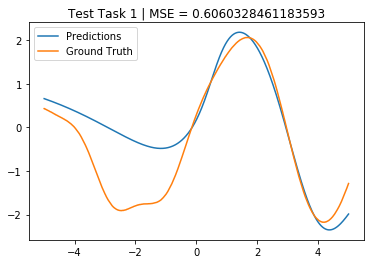

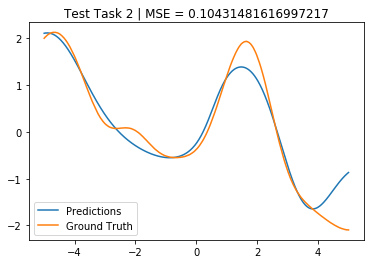

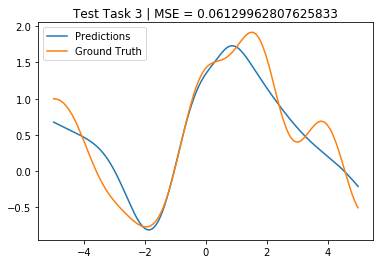

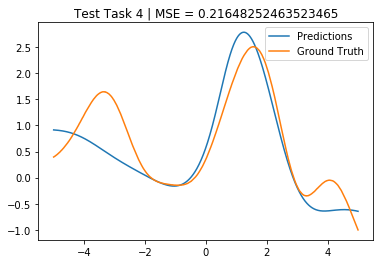

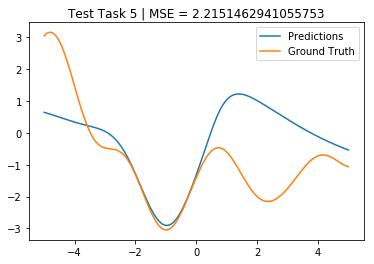

In [13]:
mean_squared_errors = []
for i, test_task in enumerate(test):
    (_, _), (Xs, F) = test_task
    pred = test_models[i].predict_f(Xs)
    plt.figure()
    plt.plot(Xs, pred[0], label='Predictions')
    plt.plot(Xs, F, label='Ground Truth')
    mse = mean_squared_error(F, pred[0])
    mean_squared_errors.append(mse)
    plt.title(f"Test Task {i + 1} | MSE = {mse}")
    plt.legend()

In [14]:
mean_mse = np.mean(mean_squared_errors)
std_mse = np.std(mean_squared_errors) / np.sqrt(num_test_tasks)
print(f"The mean MSE over all {num_test_tasks} test tasks is {mean_mse} +/- {std_mse}")

The mean MSE over all 5 test tasks is 0.6406552218210799 +/- 0.36240625035328544


We achieve comparable results to those reported in the paper.

Note: We only use 20 metatasks and 5 test tasks for scalability, whereas the paper uses 1000 and 200 respectively. Hence, there might be some discrepancies in the results.

## References
Fortuin, Vincent, and Gunnar Rätsch. "Deep Mean Functions for Meta-Learning in Gaussian Processes." arXiv preprint arXiv:1901.08098 (2019).